# Semi-Automated Data Extraction for Figure 8\n
## Rock Mechanics Q-P Plot Data Mining

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage import io, color, filters, measure, morphology, segmentation
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector
import json
from scipy.spatial.distance import cdist
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## 1. Core Functions for Semi-Automated Extraction

In [2]:
class SemiAutomatedExtractor:
    """Semi-automated data point extraction for Q-P plots"""
    
    def __init__(self, image_path):
        self.image_path = image_path
        self.image = cv2.imread(image_path)
        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.templates = {}
        self.matches = defaultdict(list)
        self.axis_limits = None
        self.plot_region = None
        
    def set_plot_region(self, x1, y1, x2, y2):
        """Define the plot area (excluding axes and labels)"""
        self.plot_region = (x1, y1, x2, y2)
        self.plot_image = self.image_rgb[y1:y2, x1:x2]
        return self.plot_image
    
    def set_axis_limits(self, x_min, x_max, y_min, y_max):
        """Set the data coordinate limits"""
        self.axis_limits = {
            'x_min': x_min, 'x_max': x_max,
            'y_min': y_min, 'y_max': y_max
        }
    
    def add_template(self, name, x, y, width, height):
        """Extract a template from user selection"""
        if self.plot_region:
            x1, y1, x2, y2 = self.plot_region
            # Adjust coordinates relative to plot region
            template = self.image[y1+y:y1+y+height, x1+x:x1+x+width]
        else:
            template = self.image[y:y+height, x:x+width]
        
        self.templates[name] = {
            'image': template,
            'gray': cv2.cvtColor(template, cv2.COLOR_BGR2GRAY),
            'size': (width, height)
        }
        return template
    
    def match_template(self, template_name, threshold=0.7):
        """Find all matches for a given template"""
        if template_name not in self.templates:
            return []
        
        template = self.templates[template_name]['gray']
        search_image = cv2.cvtColor(self.plot_image, cv2.COLOR_RGB2GRAY)
        
        # Multi-scale template matching
        scales = [0.9, 1.0, 1.1]
        all_matches = []
        
        for scale in scales:
            # Resize template
            width = int(template.shape[1] * scale)
            height = int(template.shape[0] * scale)
            resized = cv2.resize(template, (width, height))
            
            # Match template
            result = cv2.matchTemplate(search_image, resized, cv2.TM_CCOEFF_NORMED)
            
            # Find peaks
            locations = np.where(result >= threshold)
            
            for pt in zip(*locations[::-1]):
                # Calculate center point
                cx = pt[0] + width // 2
                cy = pt[1] + height // 2
                all_matches.append({
                    'x': cx,
                    'y': cy,
                    'score': result[pt[1], pt[0]],
                    'scale': scale
                })
        
        # Remove duplicates using non-maximum suppression
        filtered_matches = self.non_max_suppression(all_matches)
        self.matches[template_name] = filtered_matches
        
        return filtered_matches
    
    def non_max_suppression(self, matches, distance_threshold=10):
        """Remove duplicate detections"""
        if not matches:
            return []
        
        # Sort by score
        matches = sorted(matches, key=lambda x: x['score'], reverse=True)
        
        keep = []
        for match in matches:
            # Check if this match is too close to any already kept match
            too_close = False
            for kept in keep:
                dist = np.sqrt((match['x'] - kept['x'])**2 + (match['y'] - kept['y'])**2)
                if dist < distance_threshold:
                    too_close = True
                    break
            
            if not too_close:
                keep.append(match)
        
        return keep
    
    def pixel_to_data(self, pixel_x, pixel_y):
        """Convert pixel coordinates to data coordinates"""
        if not self.axis_limits or not self.plot_region:
            return None, None
        
        x1, y1, x2, y2 = self.plot_region
        plot_width = x2 - x1
        plot_height = y2 - y1
        
        # Linear transformation
        data_x = self.axis_limits['x_min'] + \
                 (pixel_x / plot_width) * (self.axis_limits['x_max'] - self.axis_limits['x_min'])
        
        # Y-axis is inverted in images
        data_y = self.axis_limits['y_max'] - \
                 (pixel_y / plot_height) * (self.axis_limits['y_max'] - self.axis_limits['y_min'])
        
        return data_x, data_y
    
    def visualize_matches(self, save_path=None):
        """Visualize all detected points"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.imshow(self.image_rgb)
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.templates)))
        
        x1, y1, x2, y2 = self.plot_region
        
        for i, (name, matches) in enumerate(self.matches.items()):
            for match in matches:
                # Adjust coordinates back to full image
                px = x1 + match['x']
                py = y1 + match['y']
                ax.plot(px, py, 'o', color=colors[i], markersize=8, 
                       markeredgecolor='black', markeredgewidth=0.5)
            
            # Add legend entry
            ax.plot([], [], 'o', color=colors[i], markersize=8, label=f'{name} (n={len(matches)})')
        
        # Draw plot region
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_title('Detected Data Points')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def export_data(self, metadata=None):
        """Export extracted data with metadata"""
        data = {
            'source': self.image_path,
            'axis_limits': self.axis_limits,
            'extraction_method': 'semi-automated template matching',
            'data_series': {}
        }
        
        if metadata:
            data['metadata'] = metadata
        
        for name, matches in self.matches.items():
            points = []
            for match in matches:
                data_x, data_y = self.pixel_to_data(match['x'], match['y'])
                if data_x is not None:
                    points.append({
                        'P': round(data_x, 2),
                        'Q': round(data_y, 2),
                        'confidence': round(match['score'], 3)
                    })
            
            data['data_series'][name] = {
                'points': points,
                'count': len(points)
            }
        
        return data

## 2. Interactive Template Selection Tool

In [3]:
class InteractiveTemplateSelector:
    """Interactive tool for selecting templates"""
    
    def __init__(self, extractor):
        self.extractor = extractor
        self.selections = []
        self.current_rect = None
        
    def select_templates(self, template_names):
        """Interactive template selection"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.imshow(self.extractor.image_rgb)
        ax.set_title(f'Click and drag to select template for: {template_names[0]}')
        
        self.template_names = template_names
        self.current_idx = 0
        self.ax = ax
        self.fig = fig
        
        def on_select(eclick, erelease):
            x1, y1 = int(eclick.xdata), int(eclick.ydata)
            x2, y2 = int(erelease.xdata), int(erelease.ydata)
            
            # Ensure positive width/height
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            
            # Store selection
            self.selections.append({
                'name': self.template_names[self.current_idx],
                'bbox': (x1, y1, x2-x1, y2-y1)
            })
            
            # Extract template
            self.extractor.add_template(
                self.template_names[self.current_idx],
                x1, y1, x2-x1, y2-y1
            )
            
            # Move to next template
            self.current_idx += 1
            if self.current_idx < len(self.template_names):
                ax.set_title(f'Click and drag to select template for: {self.template_names[self.current_idx]}')
            else:
                ax.set_title('Template selection complete!')
                plt.close()
        
        selector = RectangleSelector(ax, on_select, 
                                   useblit=True,
                                   button=[1],
                                   minspanx=5, minspany=5,
                                   spancoords='pixels',
                                   interactive=True)
        
        plt.show()
        return self.selections

## 3. Figure 8 Specific Implementation

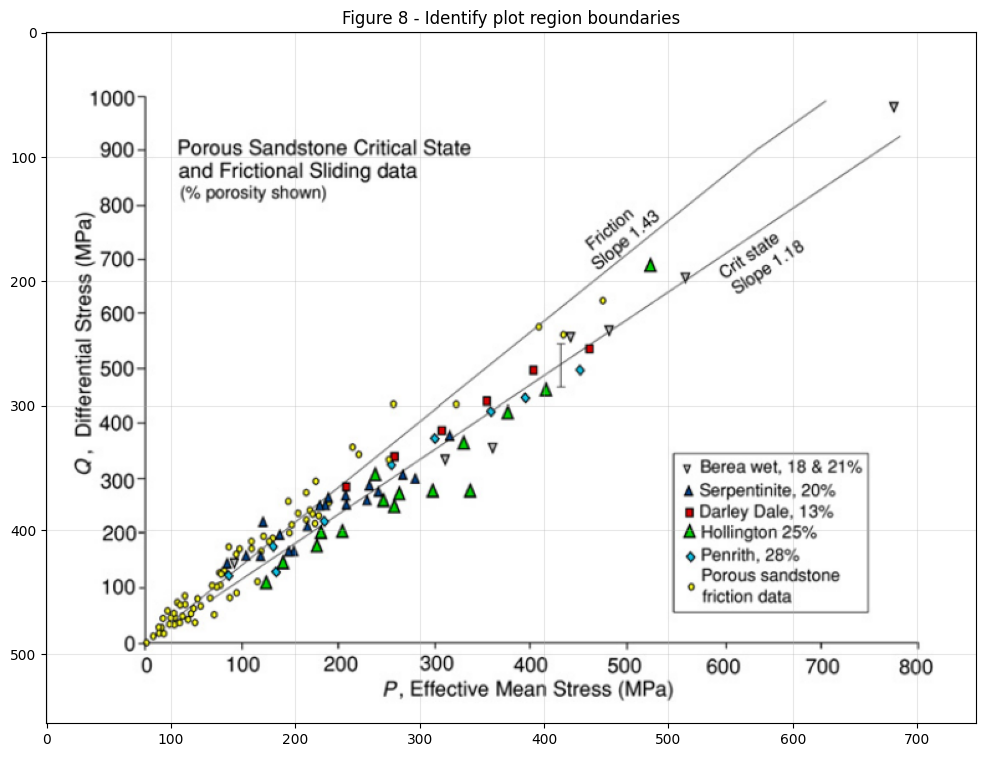

In [5]:
# Load Figure 8
fig8_path = 'fig8.png'
extractor = SemiAutomatedExtractor(fig8_path)

# Display the image to identify plot region
plt.figure(figsize=(12, 10))
plt.imshow(extractor.image_rgb)
plt.title('Figure 8 - Identify plot region boundaries')
plt.grid(True, alpha=0.3)
plt.show()

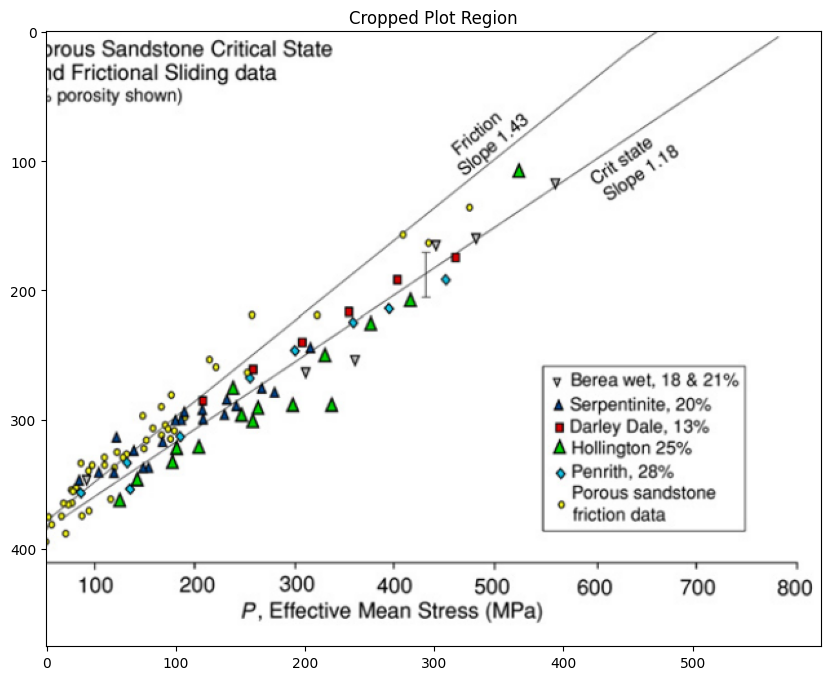

In [6]:
# Set plot region (adjust these values based on the image)
# These are approximate values - adjust as needed
plot_x1, plot_y1 = 120, 80   # Top-left corner of plot area
plot_x2, plot_y2 = 720, 580  # Bottom-right corner of plot area

plot_region = extractor.set_plot_region(plot_x1, plot_y1, plot_x2, plot_y2)

# Set axis limits from the paper
extractor.set_axis_limits(
    x_min=0,    # P min (MPa)
    x_max=800,  # P max (MPa)
    y_min=0,    # Q min (MPa)
    y_max=1000  # Q max (MPa)
)

# Display the cropped plot region
plt.figure(figsize=(10, 8))
plt.imshow(plot_region)
plt.title('Cropped Plot Region')
plt.show()

In [7]:
# Define the sandstone types from Figure 8
sandstone_types = [
    'Penrith_28',      # 28% porosity - circles
    'Hollington_25',   # 25% porosity - diamonds
    'Berea_wet_21',    # 21% porosity - inverted triangles
    'Serpentinite_20', # 20% porosity - upright triangles
    'Darley_Dale_13',  # 13% porosity - squares
    'Friction_data'    # Porous sandstone friction - stars
]

# Interactive template selection
selector = InteractiveTemplateSelector(extractor)
print("Please select one example of each symbol type by clicking and dragging.")
print("The order is:", sandstone_types)

Please select one example of each symbol type by clicking and dragging.
The order is: ['Penrith_28', 'Hollington_25', 'Berea_wet_21', 'Serpentinite_20', 'Darley_Dale_13', 'Friction_data']


In [8]:
# For non-interactive mode, manually define template regions
# (Replace with actual coordinates from interactive selection)
manual_templates = [
    ('Penrith_28', 300, 200, 20, 20),
    ('Hollington_25', 260, 270, 20, 20),
    ('Berea_wet_21', 330, 320, 20, 20),
    ('Serpentinite_20', 230, 370, 20, 20),
    ('Darley_Dale_13', 380, 420, 20, 20),
    ('Friction_data', 430, 470, 20, 20)
]

# Add templates manually if interactive selection not used
for name, x, y, w, h in manual_templates:
    extractor.add_template(name, x, y, w, h)

In [9]:
# Perform template matching for all sandstone types
results = {}
for sandstone in sandstone_types:
    matches = extractor.match_template(sandstone, threshold=0.7)
    results[sandstone] = len(matches)
    print(f"{sandstone}: {len(matches)} points detected")

# Visualize all matches
extractor.visualize_matches(save_path='fig8_detected_points.png')

Penrith_28: 6 points detected
Hollington_25: 3009 points detected


KeyboardInterrupt: 

In [ ]:
# Export data with metadata
metadata = {
    'paper': 'Rutter & Glover 2012',
    'figure': 'Figure 8',
    'description': 'Comparison of data from 4 sandstones',
    'porosity_values': {
        'Penrith': 28,
        'Hollington': 25,
        'Berea_wet': 21,
        'Serpentinite': 20,
        'Darley_Dale': 13
    },
    'trend_lines': [
        {'name': 'Friction', 'slope': 1.43},
        {'name': 'Critical State', 'slope': 1.18}
    ]
}

extracted_data = extractor.export_data(metadata)

# Save to JSON
with open('fig8_extracted_data.json', 'w') as f:
    json.dump(extracted_data, f, indent=2)

print("Data extraction complete!")
print(f"Total points extracted: {sum(results.values())}")

## 4. Data Validation and Visualization

In [ ]:
# Convert to DataFrame for analysis
all_points = []
for series_name, series_data in extracted_data['data_series'].items():
    for point in series_data['points']:
        all_points.append({
            'series': series_name,
            'P': point['P'],
            'Q': point['Q'],
            'confidence': point['confidence']
        })

df = pd.DataFrame(all_points)

# Plot extracted data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original image
ax1.imshow(extractor.image_rgb)
ax1.set_title('Original Figure 8')
ax1.axis('off')

# Extracted data plot
colors = plt.cm.tab10(np.linspace(0, 1, len(sandstone_types)))
for i, sandstone in enumerate(sandstone_types):
    series_data = df[df['series'] == sandstone]
    if not series_data.empty:
        ax2.scatter(series_data['P'], series_data['Q'], 
                   color=colors[i], label=sandstone, s=50, alpha=0.7)

# Add trend lines
p_range = np.linspace(0, 800, 100)
ax2.plot(p_range, 1.43 * p_range, 'k--', label='Friction (1.43)', linewidth=2)
ax2.plot(p_range, 1.18 * p_range, 'k:', label='Critical State (1.18)', linewidth=2)

ax2.set_xlabel('Effective mean stress, P (MPa)')
ax2.set_ylabel('Differential stress, Q (MPa)')
ax2.set_xlim(0, 800)
ax2.set_ylim(0, 1000)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_title('Extracted Data Points')

plt.tight_layout()
plt.savefig('fig8_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nExtraction Summary:")
print(df.groupby('series').agg({
    'P': ['count', 'min', 'max'],
    'Q': ['min', 'max'],
    'confidence': 'mean'
}).round(2))

## 5. Batch Processing Pipeline

In [ ]:
def process_multiple_figures(figure_configs):
    """Process multiple figures with saved templates"""
    
    all_results = {}
    
    for config in figure_configs:
        print(f"\nProcessing {config['name']}...")
        
        # Create extractor
        extractor = SemiAutomatedExtractor(config['path'])
        
        # Set plot region and axis limits
        extractor.set_plot_region(*config['plot_region'])
        extractor.set_axis_limits(**config['axis_limits'])
        
        # Load templates if available
        if 'templates' in config:
            for template in config['templates']:
                extractor.add_template(**template)
        
        # Match all templates
        for template_name in extractor.templates:
            matches = extractor.match_template(template_name)
            print(f"  {template_name}: {len(matches)} points")
        
        # Export data
        data = extractor.export_data(config.get('metadata', {}))
        all_results[config['name']] = data
        
        # Save individual results
        output_file = config['name'].replace(' ', '_') + '_data.json'
        with open(output_file, 'w') as f:
            json.dump(data, f, indent=2)
    
    return all_results

# Example configuration for batch processing
figure_configs = [
    {
        'name': 'Figure 8',
        'path': 'fig 8.png',
        'plot_region': (120, 80, 720, 580),
        'axis_limits': {'x_min': 0, 'x_max': 800, 'y_min': 0, 'y_max': 1000},
        'templates': [
            {'name': 'Penrith_28', 'x': 300, 'y': 200, 'width': 20, 'height': 20},
            # Add more templates...
        ],
        'metadata': {
            'paper': 'Rutter & Glover 2012',
            'figure': 'Figure 8'
        }
    },
    # Add more figures...
]

## 6. Performance Metrics and Validation

In [ ]:
def calculate_extraction_metrics(extracted_data, ground_truth=None):
    """Calculate performance metrics for extraction"""
    
    metrics = {
        'total_points': 0,
        'series_counts': {},
        'confidence_stats': {}
    }
    
    for series_name, series_data in extracted_data['data_series'].items():
        points = series_data['points']
        metrics['total_points'] += len(points)
        metrics['series_counts'][series_name] = len(points)
        
        if points:
            confidences = [p['confidence'] for p in points]
            metrics['confidence_stats'][series_name] = {
                'mean': np.mean(confidences),
                'std': np.std(confidences),
                'min': np.min(confidences),
                'max': np.max(confidences)
            }
    
    # If ground truth is available, calculate accuracy
    if ground_truth:
        # Implementation for accuracy calculation
        pass
    
    return metrics

# Calculate metrics for Figure 8
metrics = calculate_extraction_metrics(extracted_data)
print("\nExtraction Metrics:")
print(json.dumps(metrics, indent=2))